## Visualization of One Election 
#### It performs MDS on the data and outputs the candidates and voters positions on a single axis 


In [2]:
import seaborn as sns

from scipy.stats import kurtosis, skew

from rcv_distribution import *
from MDS_analysis import *
from voting_rules import *
from consistency import *

##### Assign csv to the path of the file you are wishing to analyse

c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'DEM Golden, Jared F.': 0.0, 'Bond, Tiffany L.': 1.0351192331574113, 'Hoar, William R.S.': 1.7820963667714376, 'REP Poliquin, Bruce': 3.0}


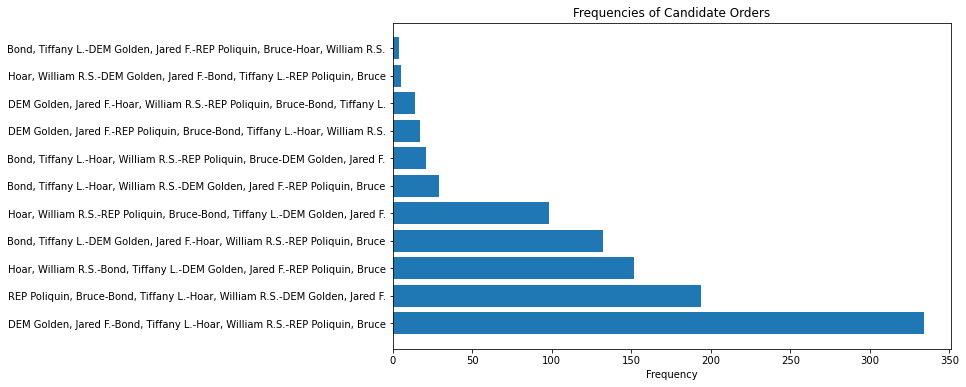

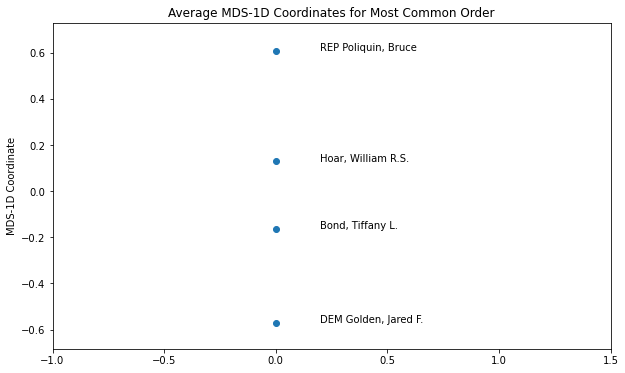

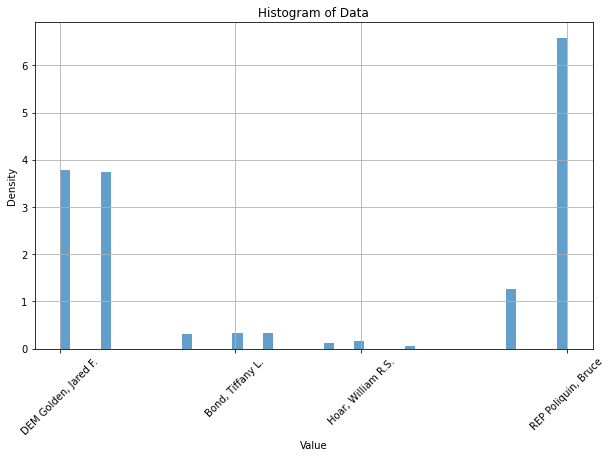

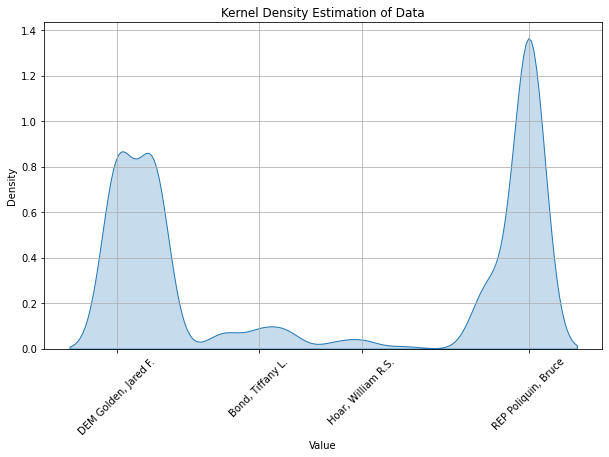

In [5]:
# Test the function with a custom CSV file
csv = "dataverse_files/Maine_11062018_CongressionalDistrict2.csv"

ballots, candidates = parse_election_data(csv)

# Perform the RCV analysis
test = perform_rcv_analysis(ballots, candidates, n_runs=1000, metric=False)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(ballots, candidates, normalized_distances)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [3]:
# Test the function with a custom CSV file
csv = "dataverse_files/Maine_11062018_CongressionalDistrict2.csv"

ballots, candidates = parse_election_data(csv)

In [4]:
test = perform_rcv_analysis(ballots, candidates, n_runs=1000, metric=False)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)


c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'DEM Golden, Jared F.': 0.0, 'Bond, Tiffany L.': 1.0378033498543893, 'Hoar, William R.S.': 1.747018064567746, 'REP Poliquin, Bruce': 3.0}


In [5]:
for b in ballots:
    if len(b) > 0 and is_consistent(b, normalized_distances):
        print(b, " is consistent")

('REP Poliquin, Bruce',)  is consistent
('DEM Golden, Jared F.', 'Bond, Tiffany L.')  is consistent
('Hoar, William R.S.', 'REP Poliquin, Bruce', 'Bond, Tiffany L.', 'DEM Golden, Jared F.')  is consistent
('DEM Golden, Jared F.', 'Bond, Tiffany L.', 'Hoar, William R.S.', 'REP Poliquin, Bruce')  is consistent
('REP Poliquin, Bruce', 'Hoar, William R.S.', 'Bond, Tiffany L.', 'DEM Golden, Jared F.')  is consistent
('Hoar, William R.S.', 'Bond, Tiffany L.', 'REP Poliquin, Bruce', 'DEM Golden, Jared F.')  is consistent
('DEM Golden, Jared F.',)  is consistent
('DEM Golden, Jared F.', 'Hoar, William R.S.', 'REP Poliquin, Bruce')  is consistent
('DEM Golden, Jared F.', 'Bond, Tiffany L.', 'Hoar, William R.S.')  is consistent
('Bond, Tiffany L.', 'DEM Golden, Jared F.', 'Hoar, William R.S.')  is consistent
('REP Poliquin, Bruce', 'Hoar, William R.S.')  is consistent
('Bond, Tiffany L.', 'Hoar, William R.S.')  is consistent
('REP Poliquin, Bruce', 'Hoar, William R.S.', 'Bond, Tiffany L.')  is c

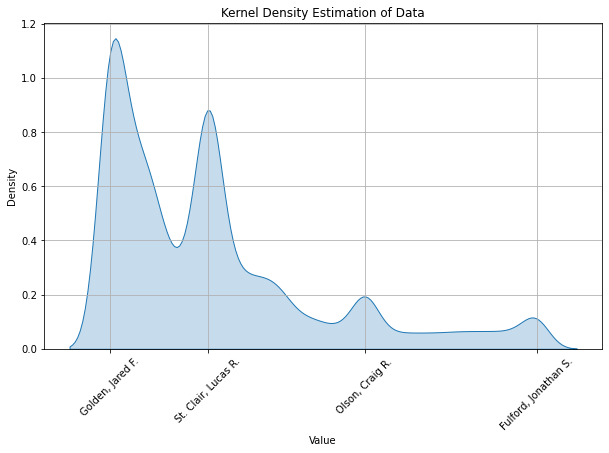

In [2]:
normalized_distances = {'Golden, Jared F.': 0.0, 'St. Clair, Lucas R.': 0.694228146564781, 'Olson, Craig R.': 1.7932149099284096, 'Fulford, Jonathan S.': 3.0}
csv = "dataverse_files/Maine_06122018_DemocraticPrimaryforCD2.csv"
ballots, candidates = parse_election_data(csv)

plot_KDE(ballots, normalized_distances)

#### run this cell to see the bimodality and gamma indices

In [6]:
#ballots, candidates = parse_election_data(csv)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate bimodality coefficient
n = len(data_points)
bimodality = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Bimodality coefficient:", bimodality)
print("Permissive Gamma coefficiet:", get_permissive_gamma(ballots, normalized_distances)[1])
print("Strict Gamma coefficiet:", get_strict_gamma(ballots, normalized_distances))



Bimodality coefficient: 0.912590212037788
Permissive Gamma coefficiet: 0.8437871576328024
Strict Gamma coefficiet: 0.8033906716893734


#### winner under different RCV methods 

In [4]:

election = voting_rules(ballots, candidates)
print("IRV: ", election.irv())
print("Condorcet: ", election.condorcet())
print("Black: ", election.black())
print("Borda: ", election.borda())
print("Bucklin: ", election.bucklin())
print("Ranked Pairs: ", election.ranked_pairs())
print("Copeland: ", election.copeland())
print("mini_max: ", election.mini_max())
print("Plurality: ", election.plurality())
print("Majority: ", election.majority())
print("Approval: ", election.approval())

IRV:  DEM Golden, Jared F.
Condorcet:  DEM Golden, Jared F.
Black:  DEM Golden, Jared F.
Borda:  DEM Golden, Jared F.
Bucklin:  DEM Golden, Jared F.
Ranked Pairs:  DEM Golden, Jared F.
Copeland:  DEM Golden, Jared F.
mini_max:  DEM Golden, Jared F.
Plurality:  REP Poliquin, Bruce
Majority:  -1
Approval:  DEM Golden, Jared F.


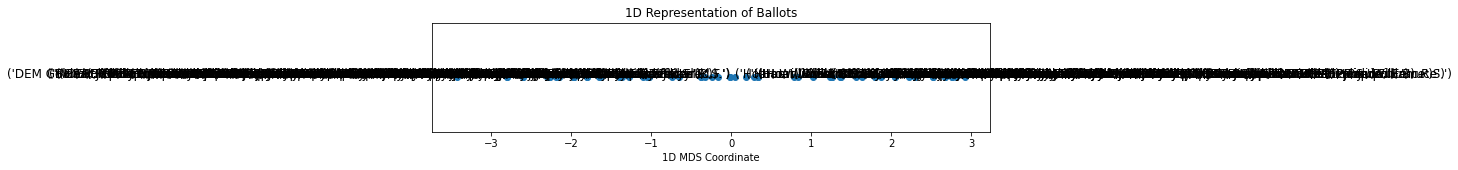

In [12]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Sample ballots
"""ballots = {
    ('A', 'B', 'D'): 123, 
    ('B', 'C'): 342, 
    ('A', 'C', 'B'): 543, 
    ('D', 'C'): 102, 
    ('A',): 233,
    ('C', 'D',): 28
}"""

csv = "dataverse_files/Maine_11062018_CongressionalDistrict2.csv"

ballots, candidates = parse_election_data(csv)

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Represent each ballot as a vector
def ballot_to_vector(ballot, candidates):
    vector = []
    for candidate in candidates:
        if candidate in ballot:
            vector.append(ballot.index(candidate))
        else:
            vector.append(len(ballot))  # A large number indicating the candidate is not ranked
    return vector

ballot_vectors = np.array([ballot_to_vector(ballot, candidates) for ballot in ballots.keys()])

# Step 3: Compute the pairwise distance matrix
# Here we use the Euclidean distance
distance_matrix = pairwise_distances(ballot_vectors, metric='euclidean')

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
ballot_1d = mds.fit_transform(distance_matrix)

# Output the result
result = dict(zip(ballots.keys(), ballot_1d.flatten()))

# Visualize the result
plt.figure(figsize=(10, 2))
y = np.zeros_like(list(result.values()))
plt.scatter(list(result.values()), y)

for ballot, x in result.items():
    plt.text(x, 0, str(ballot), fontsize=12, ha='right' if x < 0 else 'left')
    
plt.title("1D Representation of Ballots")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.show()


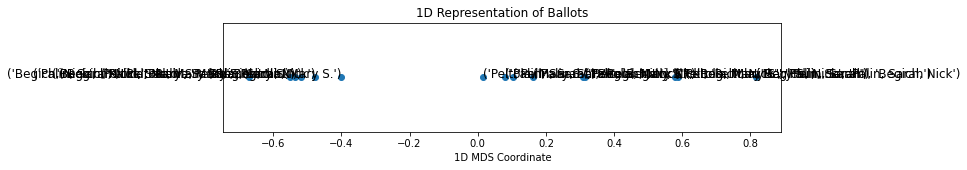

IndexError: index 15 is out of bounds for axis 0 with size 15

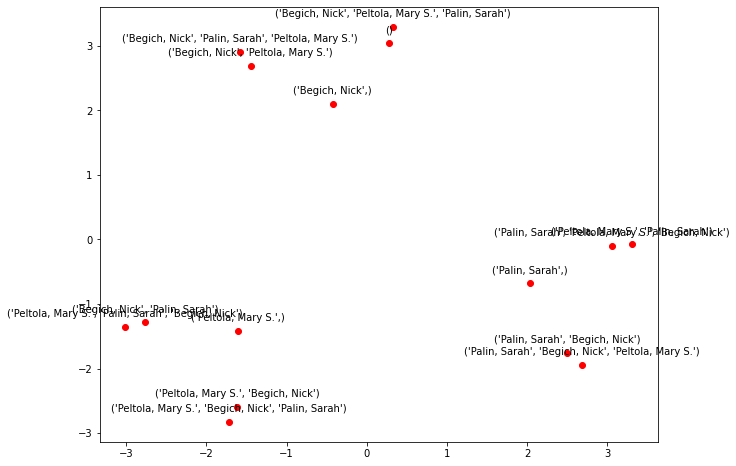

In [30]:

import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from itertools import permutations

csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)



# Sample ballots

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
"""def permutation_distance(perm1, perm2):
    # Create a mapping of candidate to position for each permutation
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    # Compute the distance based on Kendall Tau logic with adjustments for missing candidates
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance
    """

n = len(candidates)

def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if (perm1[i] != perm2[i]):
            distance += 2 ** (n - i -1)
        #print(perm1, "   ", perm2, " ", distance)
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
for b in ballot_list:
    if (len(b) == 0):
        ballot_list.remove(b)
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
 #       print(ballot_list[i], " and ", ballot_list[j], ": ", distance)

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42, metric=False)
ballot_1d = mds.fit_transform(distance_matrix)

# Output the result
result = dict(zip(ballot_list, ballot_1d.flatten()))

# Flatten the ballot positions
ballot_positions = np.array(list(result.values()))
#for b in result:
#    print(b, " ", result[b])



plt.figure(figsize=(10, 2))
y = np.zeros_like(list(result.values()))
plt.scatter(list(result.values()), y)

for ballot, x in result.items():
    plt.text(x, 0, str(ballot), fontsize=12, ha='right' if x < 0 else 'left')
    
plt.title("1D Representation of Ballots")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.show()


mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
ballot_2d = mds.fit_transform(distance_matrix)

# Step 5: Visualize the results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(ballot_2d[:, 0], ballot_2d[:, 1], c='red', label='Ballots')

# Annotate the ballots with their original tuples
for i, ballot in enumerate(ballots.keys()):
    plt.annotate(str(ballot), (ballot_2d[i, 0], ballot_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("2D MDS Visualization of Ballots")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()



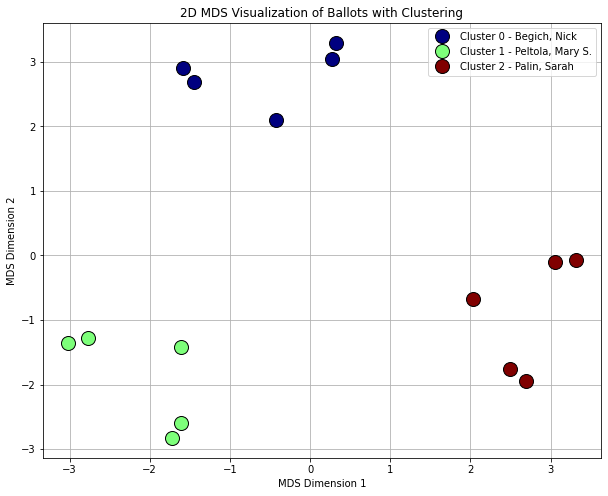

In [31]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


n_clusters = 3

# Step 6: Cluster the 2D points using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(ballot_2d)

# Step 7: Determine the most frequent first-place candidate for each cluster
cluster_candidates = defaultdict(list)
for label, ballot in zip(labels, ballots.keys()):
    if (len(ballot) > 0):
        cluster_candidates[label].append(ballot[0])

# Determine the most frequent first-place candidate for each cluster
cluster_representatives = {}
for cluster, first_places in cluster_candidates.items():
    most_common_first_place = Counter(first_places).most_common(1)[0][0]
    cluster_representatives[cluster] = most_common_first_place

# Step 8: Visualize the results
plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# Plot each cluster with its representative candidate
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = ballot_2d[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, label=f'Cluster {k} - {cluster_representatives[k]}')

plt.title("2D MDS Visualization of Ballots with Clustering")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
csv = "dataverse_files/Maine_11062018_CongressionalDistrict2.csv"

ballots, candidates = parse_election_data(csv)

In [7]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

n = len(candidates)

# Custom distance function for permutations
def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if perm1[i] != perm2[i]:
            distance += 2 ** (n - i - 1)
    return distance

# Step 2: Expand the ballot list based on their frequencies
expanded_ballot_list = []
for ballot, count in ballots.items():
    expanded_ballot_list.extend([ballot] * count)

# Ensure no empty ballots
expanded_ballot_list = [b for b in expanded_ballot_list if len(b) > 0]
n_ballots = len(expanded_ballot_list)

# Step 3: Compute the pairwise distance matrix using the custom distance function
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(expanded_ballot_list[i], expanded_ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42, metric=False)
ballot_1d = mds.fit_transform(distance_matrix)

# Step 5: Output the result and flatten the ballot positions
result = dict(zip(expanded_ballot_list, ballot_1d.flatten()))

# Step 6: Prepare data for KDE plot
positions = np.array(list(result.values()))

# Step 7: Plot the 1D positions and KDE
plt.figure(figsize=(12, 6))

# Scatter plot of ballot positions
unique_positions, counts = np.unique(positions, return_counts=True)
#plt.scatter(unique_positions, np.zeros_like(unique_positions), s=counts*10, c='red', label='Ballots')

# Annotate the ballots with their original tuples
annotated_positions = dict(zip(unique_positions, counts))
for position, count in annotated_positions.items():
    plt.text(position, 0, f'{count}', fontsize=12, ha='right' if position < 0 else 'left', rotation=45)

# KDE plot based on ballot frequencies
sns.kdeplot(positions, bw_adjust=0.5, fill=True)

plt.title("1D Representation of Ballots with KDE")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.legend()
plt.grid(True)
plt.show()


MemoryError: Unable to allocate 627. GiB for an array with shape (290149, 290149) and data type float64

In [3]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from itertools import permutations

# Sample ballots

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
"""def permutation_distance(perm1, perm2):
    # Create a mapping of candidate to position for each permutation
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    # Compute the distance based on Kendall Tau logic with adjustments for missing candidates
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance
    """

n = len(candidates)

def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if (perm1[i] != perm2[i]):
            distance += 2 ** (n - i -1)
        #print(perm1, "   ", perm2, " ", distance)
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
for b in ballot_list:
    if (len(b) == 0):
        ballot_list.remove(b)
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
 #       print(ballot_list[i], " and ", ballot_list[j], ": ", distance)

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42, metric=False)
ballot_1d = mds.fit_transform(distance_matrix)

# Output the result
result = dict(zip(ballot_list, ballot_1d.flatten()))

# Flatten the ballot positions
ballot_positions = np.array(list(result.values()))
#for b in result:
#    print(b, " ", result[b])



plt.figure(figsize=(10, 2))
y = np.zeros_like(list(result.values()))
plt.scatter(list(result.values()), y)

for ballot, x in result.items():
    plt.text(x, 0, str(ballot), fontsize=12, ha='right' if x < 0 else 'left')
    
plt.title("1D Representation of Ballots")
plt.yticks([])
plt.xlabel("1D MDS Coordinate")
plt.show()


mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
ballot_2d = mds.fit_transform(distance_matrix)

# Step 5: Visualize the results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(ballot_2d[:, 0], ballot_2d[:, 1], c='red', label='Ballots')

# Annotate the ballots with their original tuples
for i, ballot in enumerate(ballots.keys()):
    plt.annotate(str(ballot), (ballot_2d[i, 0], ballot_2d[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("2D MDS Visualization of Ballots")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()



NameError: name 'ballots' is not defined

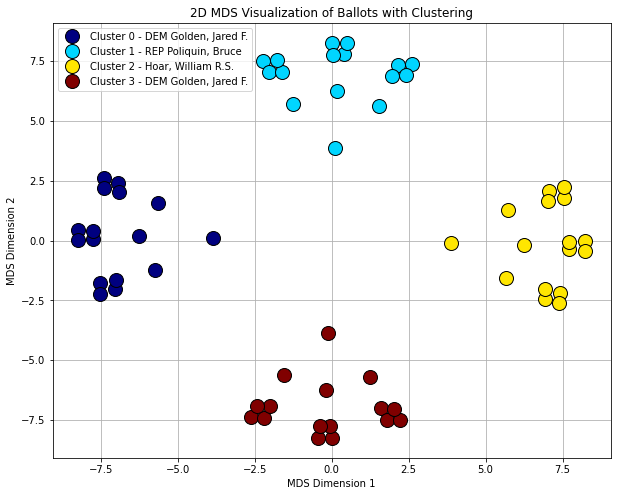

In [27]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


n_clusters = 4  

# Step 6: Cluster the 2D points using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(ballot_2d)

# Step 7: Determine the most frequent first-place candidate for each cluster
cluster_candidates = defaultdict(list)
for label, ballot in zip(labels, ballots.keys()):
    if (len(ballot) > 0):
        cluster_candidates[label].append(ballot[0])

# Determine the most frequent first-place candidate for each cluster
cluster_representatives = {}
for cluster, first_places in cluster_candidates.items():
    most_common_first_place = Counter(first_places).most_common(1)[0][0]
    cluster_representatives[cluster] = most_common_first_place

# Step 8: Visualize the results
plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# Plot each cluster with its representative candidate
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = ballot_2d[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, label=f'Cluster {k} - {cluster_representatives[k]}')

plt.title("2D MDS Visualization of Ballots with Clustering")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

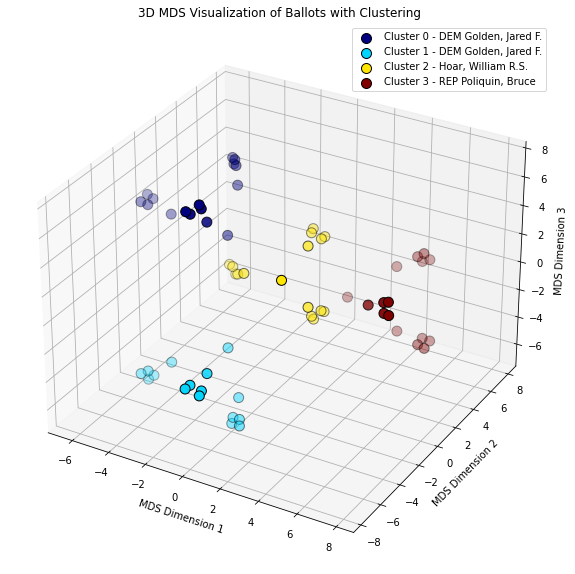

In [29]:
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
ballot_3d = mds.fit_transform(distance_matrix)

# Step 5: Specify the number of clusters
n_clusters = 4

# Step 6: Cluster the 3D points using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(ballot_3d)

# Step 7: Determine the most frequent first-place candidate for each cluster
cluster_candidates = defaultdict(list)
for label, ballot in zip(labels, ballots.keys()):
    if len(ballot) > 0:
        cluster_candidates[label].append(ballot[0])

# Determine the most frequent first-place candidate for each cluster
cluster_representatives = {}
for cluster, first_places in cluster_candidates.items():
    most_common_first_place = Counter(first_places).most_common(1)[0][0]
    cluster_representatives[cluster] = most_common_first_place

# Step 8: Visualize the results in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(labels)

# Plot each cluster with its representative candidate
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xyz = ballot_3d[class_member_mask]

    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col, label=f'Cluster {k} - {cluster_representatives[k]}', s=100, edgecolor='k')

ax.set_title("3D MDS Visualization of Ballots with Clustering")
ax.set_xlabel("MDS Dimension 1")
ax.set_ylabel("MDS Dimension 2")
ax.set_zlabel("MDS Dimension 3")
ax.legend()
plt.show()

In [6]:
csv = "dataverse_files/NewYorkCity_06222021_DEMCouncilMember35thCouncilDistrict.csv"

ballots, candidates = parse_election_data(csv)

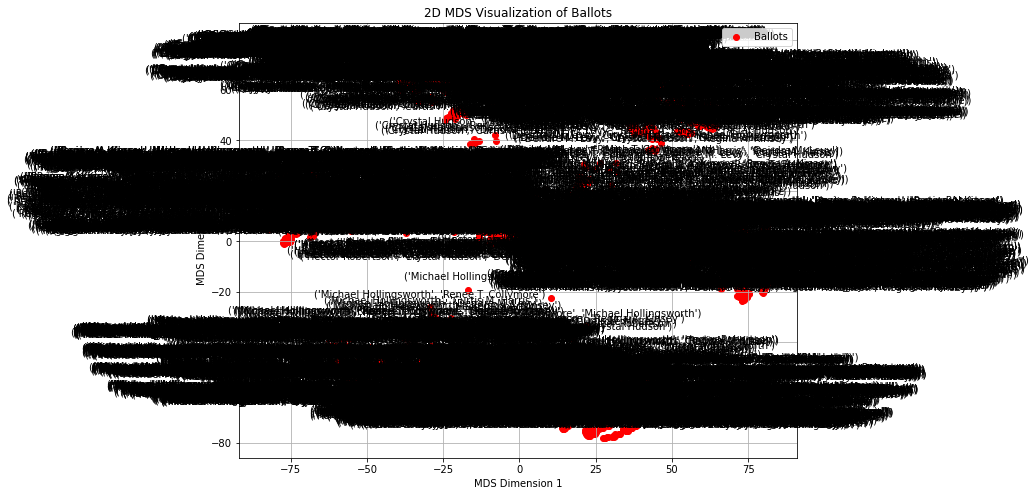

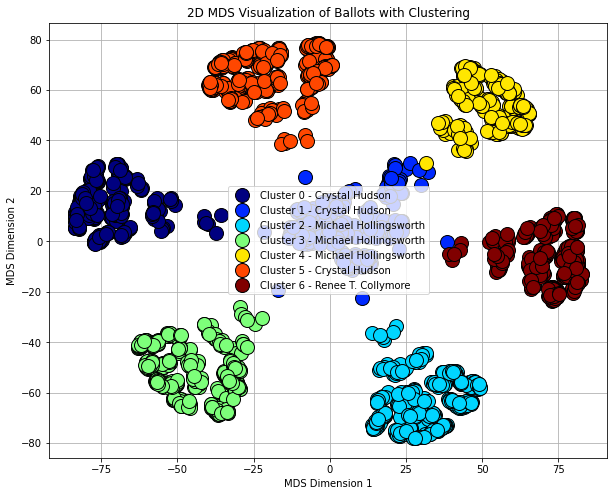

In [7]:

import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from itertools import permutations


# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
"""def permutation_distance(perm1, perm2):
    # Create a mapping of candidate to position for each permutation
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    # Compute the distance based on Kendall Tau logic with adjustments for missing candidates
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance
    """

n = len(candidates)

def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if (perm1[i] != perm2[i]):
            distance += 2 ** (n - i -1)
        #print(perm1, "   ", perm2, " ", distance)
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
for b in ballot_list:
    if (len(b) == 0):
        ballot_list.remove(b)
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
 #       print(ballot_list[i], " and ", ballot_list[j], ": ", distance)


mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
ballot_2d = mds.fit_transform(distance_matrix)

# Step 5: Visualize the results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(ballot_2d[:, 0], ballot_2d[:, 1], c='red', label='Ballots')

# Annotate the ballots with their original tuples
for i, ballot in enumerate(ballots.keys()):
    plt.annotate(str(ballot), (ballot_2d[i-1, 0], ballot_2d[i-1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("2D MDS Visualization of Ballots")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


n_clusters = 7  

# Step 6: Cluster the 2D points using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(ballot_2d)

# Step 7: Determine the most frequent first-place candidate for each cluster
cluster_candidates = defaultdict(list)
for label, ballot in zip(labels, ballots.keys()):
    if (len(ballot) > 0):
        cluster_candidates[label].append(ballot[0])

# Determine the most frequent first-place candidate for each cluster
cluster_representatives = {}
for cluster, first_places in cluster_candidates.items():
    most_common_first_place = Counter(first_places).most_common(1)[0][0]
    cluster_representatives[cluster] = most_common_first_place

# Step 8: Visualize the results
plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# Plot each cluster with its representative candidate
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = ballot_2d[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, label=f'Cluster {k} - {cluster_representatives[k]}')

plt.title("2D MDS Visualization of Ballots with Clustering")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
ny_election = voting_rules(ballots, candidates)
print(ny_election.irv())

Crystal Hudson


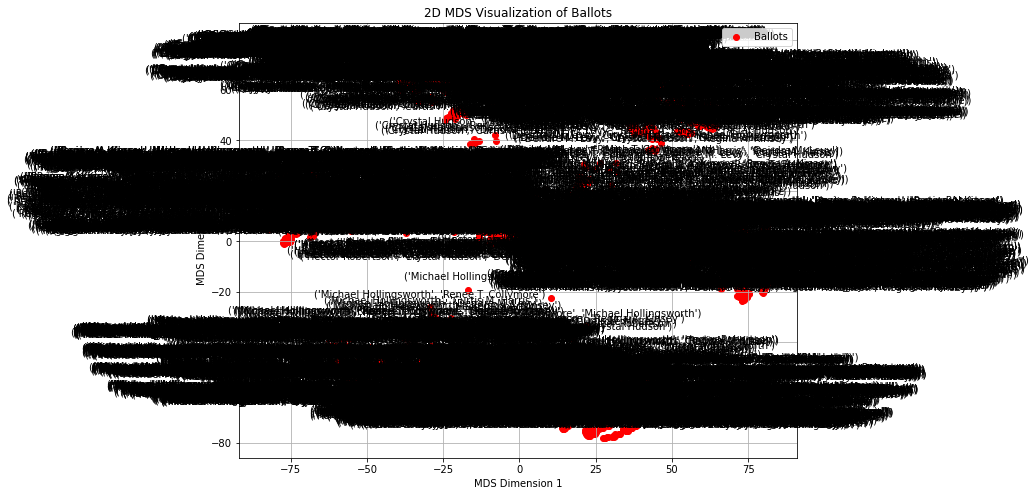

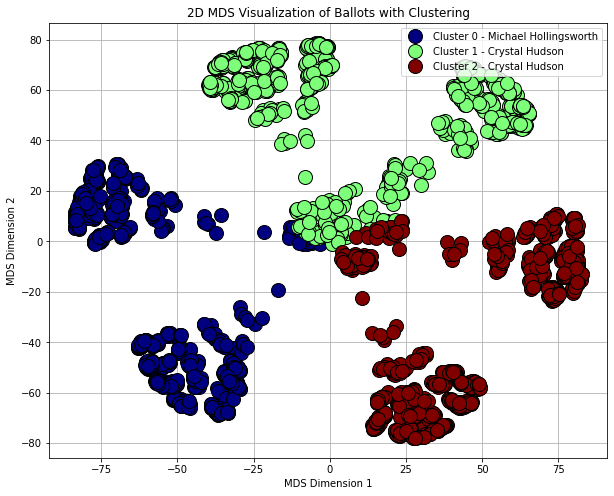

In [9]:

import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from itertools import permutations


# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
"""def permutation_distance(perm1, perm2):
    # Create a mapping of candidate to position for each permutation
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    # Compute the distance based on Kendall Tau logic with adjustments for missing candidates
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance
    """

n = len(candidates)

def permutation_distance(perm1, perm2):
    distance = 0
    for i in range(min(len(perm1), len(perm2))):
        if (perm1[i] != perm2[i]):
            distance += 2 ** (n - i -1)
        #print(perm1, "   ", perm2, " ", distance)
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
for b in ballot_list:
    if (len(b) == 0):
        ballot_list.remove(b)
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
 #       print(ballot_list[i], " and ", ballot_list[j], ": ", distance)


mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
ballot_2d = mds.fit_transform(distance_matrix)

# Step 5: Visualize the results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(ballot_2d[:, 0], ballot_2d[:, 1], c='red', label='Ballots')

# Annotate the ballots with their original tuples
for i, ballot in enumerate(ballots.keys()):
    plt.annotate(str(ballot), (ballot_2d[i-1, 0], ballot_2d[i-1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("2D MDS Visualization of Ballots")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


n_clusters = 3  

# Step 6: Cluster the 2D points using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(ballot_2d)

# Step 7: Determine the most frequent first-place candidate for each cluster
cluster_candidates = defaultdict(list)
for label, ballot in zip(labels, ballots.keys()):
    if (len(ballot) > 0):
        cluster_candidates[label].append(ballot[0])

# Determine the most frequent first-place candidate for each cluster
cluster_representatives = {}
for cluster, first_places in cluster_candidates.items():
    most_common_first_place = Counter(first_places).most_common(1)[0][0]
    cluster_representatives[cluster] = most_common_first_place

# Step 8: Visualize the results
plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# Plot each cluster with its representative candidate
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = ballot_2d[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14, label=f'Cluster {k} - {cluster_representatives[k]}')

plt.title("2D MDS Visualization of Ballots with Clustering")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

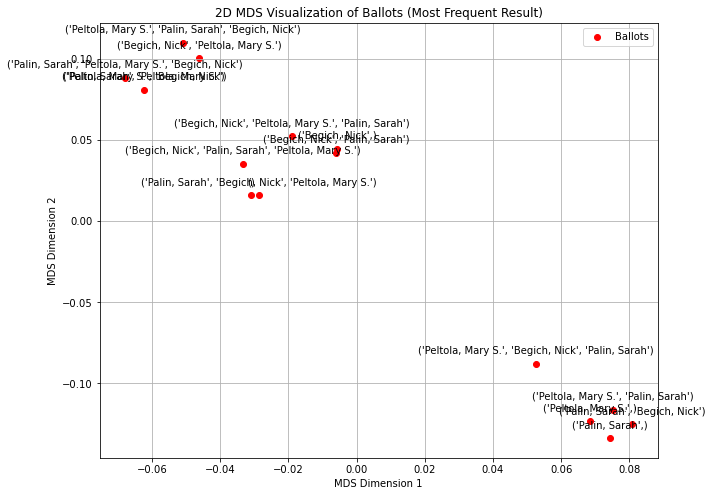

In [21]:
from sklearn.cluster import DBSCAN
results = []
for i in range(100):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=i)
    ballot_2d = mds.fit_transform(distance_matrix)
    results.append(ballot_2d)

# Step 5: Cluster the results to find the most frequent configuration
results_array = np.array(results).reshape(100, -1)
clustering = DBSCAN(eps=0.1, min_samples=2).fit(results_array)
most_common_label = Counter(clustering.labels_).most_common(1)[0][0]

# Extract the results corresponding to the most common cluster
most_common_results = results_array[clustering.labels_ == most_common_label]
most_common_result = most_common_results.mean(axis=0).reshape(-1, 2)

# Step 6: Visualize the most frequent result in 2D
plt.figure(figsize=(10, 8))
plt.scatter(most_common_result[:, 0], most_common_result[:, 1], c='red', label='Ballots')

# Annotate the ballots with their original tuples
for i, ballot in enumerate(ballots.keys()):
    plt.annotate(str(ballot), (most_common_result[i - 1, 0], most_common_result[i - 1, 1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("2D MDS Visualization of Ballots (Most Frequent Result)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

Bond, Tiffany L.   24.292438208587175
DEM Golden, Jared F.   22.1854531831311
Hoar, William R.S.   20.499865162766227
REP Poliquin, Bruce   19.23567414749261


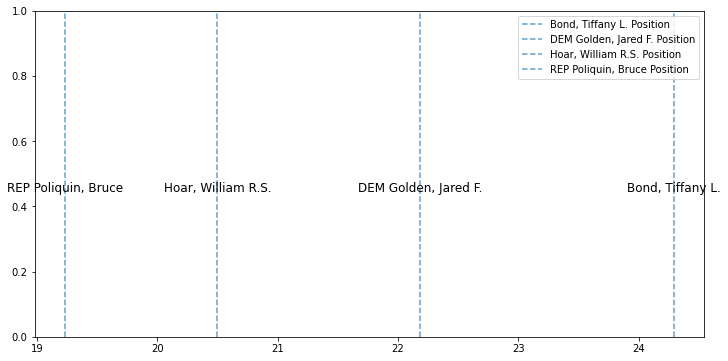

In [22]:
plt.figure(figsize=(12, 6))
#plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    point *= 100
    print(candidate, " ", point)
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.legend()
plt.show()

Begich, Nick   -41.32631506032638
Palin, Sarah   69.19796944184581
Peltola, Mary S.   10.663726662734874


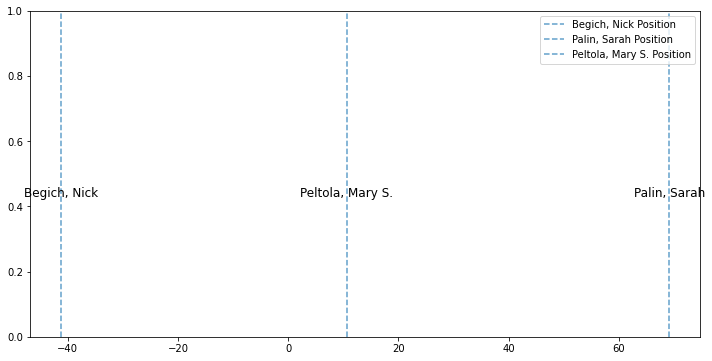

In [25]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import squareform
from collections import Counter
import matplotlib.pyplot as plt

# Sample ballots
csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)

# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Define a custom distance function for permutations
def permutation_distance(perm1, perm2):
    map1 = {candidate: idx for idx, candidate in enumerate(perm1)}
    map2 = {candidate: idx for idx, candidate in enumerate(perm2)}
    distance = 0
    for candidate in candidates:
        if candidate in map1 and candidate in map2:
            distance += abs(map1[candidate] - map2[candidate])
        elif candidate in map1 or candidate in map2:
            distance += len(candidates)  # Treat missing elements as having a large distance
    return distance

# Step 3: Compute the pairwise distance matrix using the custom distance function
ballot_list = list(ballots.keys())
n_ballots = len(ballot_list)
distance_matrix = np.zeros((n_ballots, n_ballots))

for i in range(n_ballots):
    for j in range(i + 1, n_ballots):
        distance = permutation_distance(ballot_list[i], ballot_list[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Step 4: Run the MDS process 1000 times
results = []
for _ in range(1000):
    mds = MDS(n_components=1, dissimilarity='precomputed', metric=False)
    ballot_1d = mds.fit_transform(distance_matrix)
    result = tuple(ballot_1d.flatten())
    results.append(result)

# Step 5: Determine the most frequently occurring result
most_common_result = Counter(results).most_common(1)[0][0]

# Step 6: Evaluate the density using Kernel Density Estimation for the most common result
ballot_positions = np.array(most_common_result)

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ballot_positions[:, None])

# Create a grid to evaluate the density
x_grid = np.linspace(ballot_positions.min() - 1, ballot_positions.max() + 1, 1000)[:, None]
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Step 7: Assign each candidate a point based on the density distribution
candidate_points = {}
for candidate in candidates:
    candidate_indices = [i for i, ballot in enumerate(ballot_list) if candidate in ballot]
    candidate_positions = ballot_positions[candidate_indices]
    if candidate_positions.size > 0:
        kde_candidate = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(candidate_positions[:, None])
        log_density_candidate = kde_candidate.score_samples(x_grid)
        density_candidate = np.exp(log_density_candidate)
        candidate_point = x_grid[np.argmax(density_candidate)]
        candidate_points[candidate] = candidate_point[0]

# Visualize the results
plt.figure(figsize=(12, 6))
#plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    point *= 100
    print(candidate, " ", point)
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.legend()
plt.show()


In [29]:
csv = "dataverse_files/Alaska_08162022_HouseofRepresentativesSpecial.csv"

ballots, candidates = parse_election_data(csv)

In [35]:
import numpy as np
from sklearn.manifold import MDS
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import euclidean
from collections import Counter
import matplotlib.pyplot as plt
# Step 1: Create a list of unique candidates
candidates = sorted(set(candidate for ballot in ballots for candidate in ballot))

# Step 2: Extract the first-choice candidates from each ballot
first_choice_positions = []
for ballot in ballots.keys():
    first_choice_positions.append([ballot.index(candidate) if candidate in ballot else float('inf') for candidate in candidates])

# Step 3: Run the MDS process 1000 times
first_choice_positions = np.array(first_choice_positions)
euclidean_distance_matrix = np.zeros((len(ballots), len(ballots)))

for i in range(len(ballots)):
    for j in range(i + 1, len(ballots)):
        euclidean_distance_matrix[i, j] = euclidean(first_choice_positions[i], first_choice_positions[j])
        euclidean_distance_matrix[j, i] = euclidean_distance_matrix[i, j]

# Step 4: Apply MDS to reduce dimensionality to 1
mds = MDS(n_components=1, dissimilarity='precomputed', random_state=42)
ballot_1d = mds.fit_transform(euclidean_distance_matrix)

# Step 5: Evaluate the density using Kernel Density Estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ballot_1d)

# Create a grid to evaluate the density
x_grid = np.linspace(ballot_1d.min() - 1, ballot_1d.max() + 1, 1000).reshape(-1, 1)
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Step 6: Assign each candidate a point based on the density distribution
candidate_points = {}
for candidate in candidates:
    candidate_indices = [i for i, ballot in enumerate(ballots.keys()) if candidate in ballot]
    candidate_positions = ballot_1d[candidate_indices]
    if candidate_positions.size > 0:
        kde_candidate = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(candidate_positions)
        log_density_candidate = kde_candidate.score_samples(x_grid)
        density_candidate = np.exp(log_density_candidate)
        candidate_point = x_grid[np.argmax(density_candidate)]
        candidate_points[candidate] = candidate_point[0]

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(x_grid, density, label='Overall Density')
for candidate, point in candidate_points.items():
    plt.axvline(point, linestyle='--', label=f'{candidate} Position', alpha=0.7)
    plt.text(point, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.scatter(ballot_1d, np.zeros_like(ballot_1d), color='red')
plt.title("Density of First-Choice Candidates on 1D MDS Axis (Euclidean Distance)")
plt.xlabel("1D MDS Coordinate")
plt.legend()
plt.show()

c:\Users\mahsh\anaconda3\lib\site-packages\scipy\spatial\distance.py:488: RuntimeWarning: invalid value encountered in subtract
  u_v = u - v


ValueError: array must not contain infs or NaNs

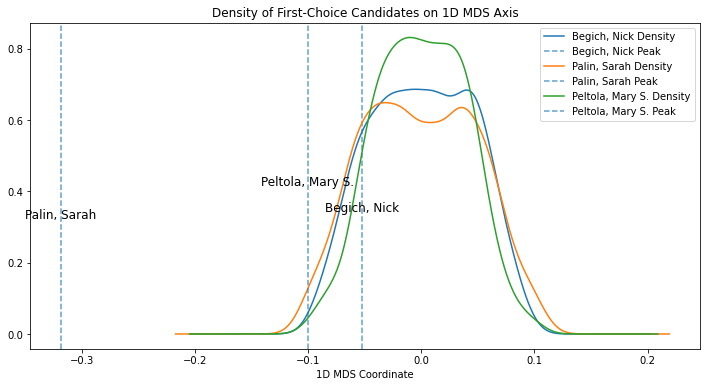

In [33]:
plt.figure(figsize=(12, 6))
for candidate, (x_grid, density) in first_choice_density.items():
    plt.plot(x_grid*0.1, density, label=f'{candidate} Density')
    max_density_pos = x_grid[np.argmax(density)]
    plt.axvline(max_density_pos, linestyle='--', label=f'{candidate} Peak', alpha=0.7)
    plt.text(max_density_pos, max(density) * 0.5, candidate, fontsize=12, ha='center', color='black')

plt.title("Density of First-Choice Candidates on 1D MDS Axis")
plt.xlabel("1D MDS Coordinate")
plt.legend()
plt.show()